In [107]:
import csv
import json
import logging
import re
from io import StringIO
from typing import Dict, List, Optional

import cv2
import numpy as np
import torch
from PIL import Image
from transformers import AutoProcessor, Qwen3VLForConditionalGeneration, BitsAndBytesConfig

qwen3-vl-2b работает плохо. 4b приемлимо

In [108]:
#from models.decorators import run_in_executor

logger = logging.getLogger(__name__)

class Qwen3DetailedAnalyzer:
    """Detailed frame analyzer using Qwen3-VL for counting creatures and extracting sensor data"""

    def __init__(
        self,
        model_name: str = "Qwen/Qwen3-VL-4B-Instruct",
        device: Optional[str] = None,
        use_quantization: bool = True,
        quantization_bits: int = 4,
    ):
        """Initialize Qwen3-VL detailed analyzer

        Args:
            model_name: HuggingFace model name (7B recommended for detailed analysis)
            device: 'cuda', 'cpu', or None for auto-detection
            use_quantization: Enable quantization to reduce VRAM (recommended)
            quantization_bits: 4 or 8 bit quantization
        """
        if device is None:
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
        else:
            self.device = device

        logger.info(f"Loading Qwen3-VL detailed analyzer: {model_name} on device: {self.device}")
        if use_quantization:
            logger.info(f"Using {quantization_bits}-bit quantization")

        # Load model with optional quantization
        model_kwargs = {}

        # Use device_map only with quantization, otherwise load to specific device
        if use_quantization and self.device == "cuda":
            

            quantization_config = BitsAndBytesConfig(
                load_in_4bit=(quantization_bits == 4),
                load_in_8bit=(quantization_bits == 8),
                bnb_4bit_compute_dtype=torch.bfloat16,
                bnb_4bit_use_double_quant=True,
                bnb_4bit_quant_type="nf4",
            )
            model_kwargs["quantization_config"] = quantization_config
            model_kwargs["device_map"] = "auto"
        else:
            # Load normally without device_map to avoid meta tensor issues
            if self.device == "cuda":
                model_kwargs["dtype"] = torch.bfloat16
            else:
                model_kwargs["dtype"] = torch.float32

        self.model = Qwen3VLForConditionalGeneration.from_pretrained(model_name, **model_kwargs)

        # Move to device if not using device_map
        if "device_map" not in model_kwargs:
            self.model = self.model.to(self.device)
        # Use slow processor for consistent behavior
        self.processor = AutoProcessor.from_pretrained(model_name, use_fast=True)
        self.model.eval()

        logger.info("Qwen3-VL detailed analyzer loaded successfully")

    #@run_in_executor
    def analyze_detailed(self, frame: np.ndarray, prompt: str) -> Dict:
        """Perform detailed analysis of frame to extract creature counts and sensor data

        Args:
            frame: Video frame as numpy array (BGR format)

        Returns:
            dict with keys:
                - creatures: List[Dict] with {class_type, species, total_count, alive_count, dead_count}
                - hygrometer: Dict with {temperature, humidity} or None if not found
                - csv_data: str with CSV formatted data
                - raw_response: str with model's raw response
        """
        try:
            # Convert BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image = Image.fromarray(frame)

            # Create detailed analysis prompt

            messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "image"},
                        {"type": "text", "text": prompt},
                    ],
                }
            ]

            # Prepare inputs
            text = self.processor.apply_chat_template(
                messages, tokenize=False, add_generation_prompt=True
            )

            # Process image and text
            inputs = self.processor(text=[text], images=[image], padding=True, return_tensors="pt")
            inputs = inputs.to(self.device)

            # Generate response with longer max tokens for detailed analysis
            output_ids = self.model.generate(
                **inputs,
                max_new_tokens=1024,
                do_sample=False,
                temperature=0.0,
            )

            # Decode the response
            generated_ids = [
                output_ids[len(input_ids) :]
                for input_ids, output_ids in zip(inputs.input_ids, output_ids)
            ]

            response = self.processor.batch_decode(
                generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
            )[0]

            # Parse JSON from response
            result = self._parse_response(response)

            # Generate CSV data
            csv_data = self._generate_csv(result)

            logger.info(
                f"Detailed analysis complete: {len(result.get('creatures', []))} creature classes found"
            )

            return {
                "creatures": result.get("creatures", []),
                "hygrometer": result.get("hygrometer"),
                "notes": result.get("notes", ""),
                "csv_data": csv_data,
                "raw_response": response,
            }

        except Exception as e:
            logger.error(f"Detailed analysis error: {e}", exc_info=True)
            return {
                "creatures": [],
                "hygrometer": None,
                "notes": f"Error during analysis: {str(e)}",
                "csv_data": "",
                "raw_response": "",
            }

    def _parse_response(self, response: str) -> dict:
        """Parse JSON response from model"""
        try:
            # Try to extract JSON from response
            json_match = re.search(r"\{.*\}", response, re.DOTALL)
            if json_match:
                result = json.loads(json_match.group())

                # Ensure required fields exist with defaults
                if "creatures" not in result:
                    result["creatures"] = []
                if "hygrometer" not in result:
                    result["hygrometer"] = None
                if "notes" not in result:
                    result["notes"] = ""

                # Validate creatures structure
                for creature in result.get("creatures", []):
                    if "class_type" not in creature:
                        creature["class_type"] = "неизвестно"
                    if "species" not in creature:
                        creature["species"] = "неизвестно"
                    if "total_count" not in creature:
                        creature["total_count"] = 0
                    if "alive_count" not in creature:
                        creature["alive_count"] = 0
                    if "dead_count" not in creature:
                        creature["dead_count"] = 0

                return result
        except Exception as e:
            logger.warning(f"Failed to parse JSON response: {e}")

        # Fallback: return empty result
        return {
            "creatures": [],
            "hygrometer": None,
            "notes": f"Failed to parse response: {response[:200]}...",
        }

    def _generate_csv(self, analysis_result: dict) -> str:
        """Generate CSV data from analysis result"""
        output = StringIO()
        writer = csv.writer(output)

        # Write creatures data
        writer.writerow(["Creature Analysis"])
        writer.writerow(["Тип класса", "Вид", "Total Count", "Alive Count", "Dead Count"])

        for creature in analysis_result.get("creatures", []):
            writer.writerow(
                [
                    creature.get("class_type", ""),
                    creature.get("species", ""),
                    creature.get("total_count", 0),
                    creature.get("alive_count", 0),
                    creature.get("dead_count", 0),
                ]
            )

        # Empty row separator
        writer.writerow([])

        # Write hygrometer data if available
        hygrometer = analysis_result.get("hygrometer")
        if hygrometer:
            writer.writerow(["Sensor Data"])
            writer.writerow(["Metric", "Value"])
            writer.writerow(["Temperature", hygrometer.get("temperature", "N/A")])
            writer.writerow(["Humidity", hygrometer.get("humidity", "N/A")])
            writer.writerow([])

        # Write notes
        notes = analysis_result.get("notes", "")
        if notes:
            writer.writerow(["Notes"])
            writer.writerow([notes])

        return output.getvalue()

    def __del__(self):
        """Cleanup resources"""
        try:
            del self.model
            del self.processor
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        except:
            pass


In [109]:
frame = Image.open('./photos/capture_20251128_150741.jpg').convert("RGB")

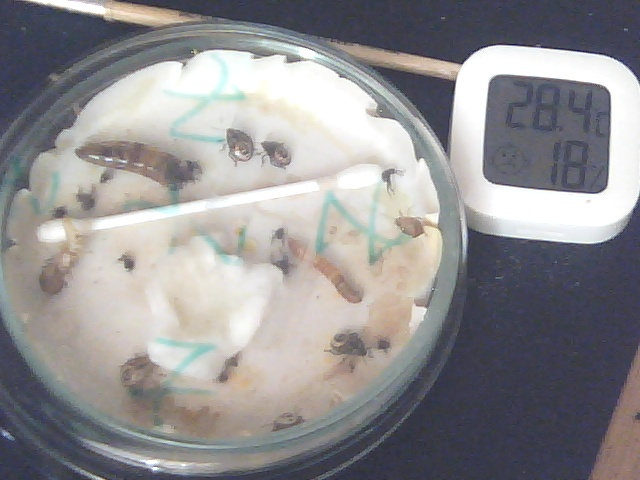

In [110]:
frame

In [111]:
model = Qwen3DetailedAnalyzer(device='cuda')

Loading weights: 100%|██████████| 713/713 [00:20<00:00, 34.88it/s, Materializing param=model.visual.pos_embed.weight]                                  


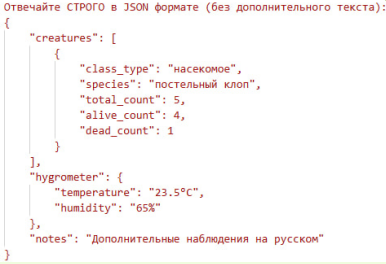

# Промпты

In [112]:
prompt_temp_ru = 'Полностью ли видны и читаемы показания температуры и влажности на термометре на этом фото? Ответьте в виде JSON-объекта "hygrometer" с полями "visibility", "temperature", "humidity". Установите "visibility" в значение true, если температура и влажность читаемы'
prompt_temp_en = 'Is temprerature and humidity on thermometer fully visible and readable on this photo? answer in JSON object "hygrometer" with field "visibility", "temperature", "humidity". Set visibility to true if temperature and humidity can be read'

prompt_incects_ru = 'На фотографии объекты трех классов: личинки, клопы, черные жуки. Будь точен. Посчитай представителей каждого указанного класса. Ответ в виде json объекта "creatures", содержащего для каждого из трех классов информацию в виде класса json объект с полями "species" со значением класса, и "total_count" c результатом подсчета'
prompt_incects_en = 'The photograph contains incects of three types: larvae, bugs, and black beetles. Count the representatives of each type. The response is a JSON array object called "creatures" containing information for each of the incects type as a JSON object with the fields: "species" containing the class value, and "total_count" containing the count result.'

In [113]:
prompt_compound_en = """result answer should be JSON object, which includes results from next queries. 
                First: Is temprerature and humidity on thermometer fully visible and readable on this photo? answer in JSON object "hygrometer" with field "visibility", "temperature", "humidity". Set "visibility" to true if temperature and humidity can be read. if something cannot be read, set value to "false".
                Second: The photograph contains incects of three types: larvae, bugs, and black beetles. Be precise. Count the representatives of each type. 
                The response is a JSON array object called "creatures" containing information for each of the incects type as a JSON object with the fields: "species" containing the class value, and "total_count" containing the count result."""

In [114]:
model.analyze_detailed(np.array(frame), prompt = prompt_compound_en)

{'creatures': [{'species': 'larvae',
   'total_count': 3,
   'class_type': 'неизвестно',
   'alive_count': 0,
   'dead_count': 0},
  {'species': 'bugs',
   'total_count': 2,
   'class_type': 'неизвестно',
   'alive_count': 0,
   'dead_count': 0},
  {'species': 'black beetles',
   'total_count': 4,
   'class_type': 'неизвестно',
   'alive_count': 0,
   'dead_count': 0}],
 'hygrometer': {'visibility': True, 'temperature': 28.4, 'humidity': 18},
 'notes': '',
 'csv_data': 'Creature Analysis\r\nТип класса,Вид,Total Count,Alive Count,Dead Count\r\nнеизвестно,larvae,3,0,0\r\nнеизвестно,bugs,2,0,0\r\nнеизвестно,black beetles,4,0,0\r\n\r\nSensor Data\r\nMetric,Value\r\nTemperature,28.4\r\nHumidity,18\r\n\r\n',
 'raw_response': '{\n  "hygrometer": {\n    "visibility": true,\n    "temperature": 28.4,\n    "humidity": 18\n  },\n  "creatures": [\n    {\n      "species": "larvae",\n      "total_count": 3\n    },\n    {\n      "species": "bugs",\n      "total_count": 2\n    },\n    {\n      "species

# Прогон

In [115]:
from pathlib import Path
from datetime import date, time, datetime
import os

def read_image(url):
    return Image.open(url)

directory_path = Path('./photos')  # Use '.' for the current directory or a specific path like Path('my_folder')

n_files = 0
for i, item in enumerate(directory_path.iterdir()):
    if item.is_file():
        n_files += 1
n_files

48

In [116]:
extracted_json_data = []

In [117]:
for i, item in enumerate(directory_path.iterdir()):
    if item.is_file():
        file_name = item.name
        print(f"№{i+1}/{n_files}: Process image {file_name}")
        img_name_data = item.name.split("_")

        date_taken = img_name_data[1]
        d = int(date_taken[6:])
        mo = int(date_taken[4:6])
        y = int(date_taken[:4])

        # date_taken = f"{date_taken[6:]}-{date_taken[4:6]}-{date_taken[:4]}"

        time_taken = img_name_data[2]
        
        h = int(time_taken[:2])
        m = int(time_taken[2:4])
        s = int(time_taken[4:6])
        
        time_taken = f"{time_taken[:2]}:{time_taken[2:4]}:{time_taken[4:6]}"

        # 1. Create a date object
        my_date = date(year=y, month=mo, day=d)

        # 2. Create a time object
        my_time = time(hour=h, minute=m, second=s)

        # 3. Combine them into a datetime object
        my_datetime = datetime.combine(my_date, my_time)

        relative_img_path = os.path.join(directory_path, file_name)

        # Загружаем изображение 

        image = read_image(
            relative_img_path
        )

        json_data = model.analyze_detailed(np.array(image), prompt = prompt_compound_en)


        json_data['file_name'] = file_name
        json_data['filmed_at'] = my_datetime.strftime('%d-%m-%Y %H:%M:%S')
        print(json_data)

        extracted_json_data.append(json_data)

№1/48: Process image capture_20251127_162538.jpg
{'creatures': [{'species': 'larvae', 'total_count': 2, 'class_type': 'неизвестно', 'alive_count': 0, 'dead_count': 0}, {'species': 'bugs', 'total_count': 5, 'class_type': 'неизвестно', 'alive_count': 0, 'dead_count': 0}, {'species': 'black beetles', 'total_count': 4, 'class_type': 'неизвестно', 'alive_count': 0, 'dead_count': 0}], 'hygrometer': {'visibility': True, 'temperature': 27.3, 'humidity': 21}, 'notes': '', 'csv_data': 'Creature Analysis\r\nТип класса,Вид,Total Count,Alive Count,Dead Count\r\nнеизвестно,larvae,2,0,0\r\nнеизвестно,bugs,5,0,0\r\nнеизвестно,black beetles,4,0,0\r\n\r\nSensor Data\r\nMetric,Value\r\nTemperature,27.3\r\nHumidity,21\r\n\r\n', 'raw_response': '{\n  "hygrometer": {\n    "visibility": true,\n    "temperature": 27.3,\n    "humidity": 21\n  },\n  "creatures": [\n    {\n      "species": "larvae",\n      "total_count": 2\n    },\n    {\n      "species": "bugs",\n      "total_count": 5\n    },\n    {\n      "sp